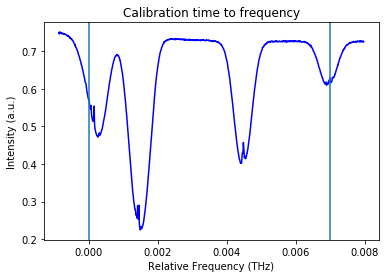

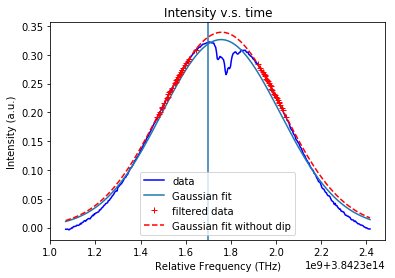

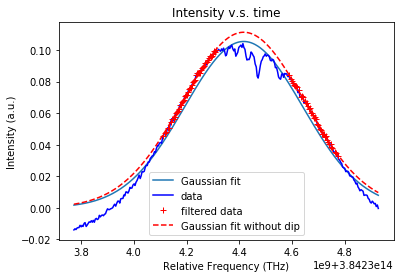

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from astropy.stats import sigma_clip
import scipy.signal as sgn

# calibration time and frequency
# the most distant 2 lines are the transition of Rb87 (left)F=2->F'=1, (right)F=1->F'=2
left = 1e12*384.23048447-1e6*229.85-1e9*2.56301
right = 1e12*384.23048447-72.91*1e6+4.27168*1e9
dif = right - left

# time, intensity and derivative of intensity
t_all,I_all,I_abl_all=np.loadtxt('Part I/All_Peaks.txt',skiprows=1,usecols=(0,1,2),unpack=True)

# find out maxima of curve
x = sgn.argrelmax(I_all)
y = t_all[x][np.where(I_all[x] < 0.7)]
z = I_all[x][np.where(I_all[x] < 0.7)]
# the left line corresponds to the first maximum, the right line corresponds to the last maximum
# according to that we can do calibration
diff = y[-1]-y[0]
t_all = (dif / diff * (t_all - y[0]) + left)

plt.plot((t_all-left)/1e12, I_all, color="blue", label="data")
m = ((dif / diff * (y - y[0]) + left)-left)/1e12
plt.axvline(m[0])
plt.axvline(m[-1])
plt.title("Calibration time to frequency")
plt.xlabel("Relative Frequency (THz)")
plt.ylabel("Intensity (a.u.)")
plt.show()

t,I,I_abl=np.loadtxt('Rb85_F2-Rb87_F1.txt',skiprows=1,usecols=(0,1,2),unpack=True)
t = (dif / diff * (t - y[0]) + left)

# Fit the data using a Gaussian
g_init0 = models.Gaussian1D(amplitude=0.3, mean=(dif / diff * (0.003 - y[0]) + left), stddev=0.5e9)
g_init1 = models.Gaussian1D(amplitude=0.1, mean=(dif / diff * (0.52 - y[0]) + left), stddev=0.5e9)
fit_g = fitting.LevMarLSQFitter()
t0 = t[0:350]
I0 = (I[0:350]-0.75)*(-1)
t1 = t[700:]
I1 = (I[700:]-0.75)*(-1)
g0 = fit_g(g_init0, t0, I0)
g1 = fit_g(g_init1, t1, I1)

or_fit = fitting.FittingWithOutlierRemoval(fit_g, sigma_clip, niter = 3, sigma_lower = 1.4)
or_fitted_model0, mask0 = or_fit(g_init0, t0, I0)
filtered_data0 = np.ma.masked_array(I0, mask=mask0)
or_fitted_model1, mask1 = or_fit(g_init1, t1, I1)
filtered_data1 = np.ma.masked_array(I1, mask=mask1)

plt.plot(t0, I0, color="blue", label="data")
plt.plot(t0, g0(t0), label='Gaussian fit')
plt.plot(t0,filtered_data0, 'r+', label="filtered data")
plt.plot(t0, or_fitted_model0(t0), 'r--',label="Gaussian fit without dip")
x0 = sgn.argrelmin(I0)
y0 = t0[x0][np.where(I0[x0] > 0.25)]
plt.axvline(y0[3])
plt.xlabel("Relative Frequency (THz)")
plt.ylabel("Intensity (a.u.)")
plt.title("Intensity v.s. time")
plt.legend()
plt.show()

plt.plot(t1, g1(t1), label='Gaussian fit')
plt.plot(t1, I1, color="blue", label="data")
plt.plot(t1,filtered_data1, 'r+', label="filtered data")
plt.plot(t1, or_fitted_model1(t1), 'r--',label="Gaussian fit without dip")
plt.xlabel("Relative Frequency (THz)")
plt.ylabel("Intensity (a.u.)")
plt.title("Intensity v.s. time")
plt.legend()
plt.show()